In [22]:
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.cluster import HDBSCAN

from util.general import list_to_parsed_set

In [23]:
# Constants
CLUSTER_KEY = "hdb_cluster"
ESPG_NUM = 4326
FIGURE_SIZE = (25, 25)
MARKER_SIZE_CLUSTER = 25
MARKER_SIZE_NON_CLUSTER = 10
VIEWPORT_X = (-87.63, -87.56)
VIEWPORT_Y = (41.77, 41.832)

In [24]:
# Utility Functions
def polars_dicts_to_geopandas(pl_dict: {str: pl.DataFrame}) -> {str: gp.GeoDataFrame}:
    gp_dict: {str: gp.GeoDataFrame} = {}
    for k in pl_dict.keys():
        gp_df = pl_dict[k].to_pandas()
        gp_df = gp.GeoDataFrame(
            gp_df,
            geometry=gp.points_from_xy(gp_df["longitude"], gp_df["latitude"]),
            crs=f"EPSG:{ESPG_NUM}",
        )
        gp_dict[k] = gp_df

    return gp_dict


def cluster_dataframes(gp_dict: {str: gp.GeoDataFrame}) -> None:
    for key in gp_dict.keys():
        df = gp_dict[key]
        point_array = np.array(
            [(point.y, point.x) for point in df.to_crs(crs=f"EPSG:{ESPG_NUM}").geometry]
        )

        print(point_array.shape)

        min_cluster_size = max(int(df.shape[0] * 0.05), 7)

        hdb = HDBSCAN(min_cluster_size=min_cluster_size).fit(point_array)
        hdb_labels = [str(label) for label in hdb.labels_]

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(hdb_labels)) - (1 if "-1" in hdb_labels else 0)
        n_noise_ = list(hdb_labels).count("-1")

        print(f"Estimated number of clusters for {key} {n_clusters_}")
        print(
            f"Estimated number of noise points for {key} {n_noise_}/{point_array.shape[0]}"
        )

        df[CLUSTER_KEY] = hdb_labels


def contains_violence(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in VIOLENCE:
            return True
    return False


def contains_sa_gb(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in SEXUAL_ASSAULT_GENDER_BASED:
            return True
    return False


def contains_narcotics(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in NARCOTICS:
            return True
    return False

def contains_incomplete(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in INCOMPLETE:
            return True
    return False


def hdbscan_plotting(df: gp.GeoDataFrame, title_suffix: str) -> None:
    gb_df = df[df.hdb_cluster != "-1"]

    hdb_fig, hdb_ax = plt.subplots(figsize=FIGURE_SIZE)
    chi_communities.to_crs(epsg=ESPG_NUM).plot(
        ax=hdb_ax, color="none", edgecolor="black"
    )
    chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=hdb_ax, color="grey")
    df.plot(ax=hdb_ax, markersize=20, color="darkgrey")
    gb_df.plot(
        column=CLUSTER_KEY,
        ax=hdb_ax,
        cmap="viridis",
        legend=True,
        markersize=45,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
    )
    hdb_ax.set_xlim(-87.63, -87.56)
    hdb_ax.set_ylim(41.77, 41.832)
    plt.title(f"HDBSCAN for {title_suffix.title().replace('And', 'and')}", fontsize=25)
    plt.savefig(f"{title_suffix.replace(' ', '-')}.png")


def create_four_seasons_png(i_dict: {str: gp.GeoDataFrame}, category: str) -> None:
    q_fig, q_ax = plt.subplots(2, 2, figsize=FIGURE_SIZE)

    q_fig.subplots_adjust(top=0.94)
    for qx in q_ax.flat:
        chi_communities.to_crs(epsg=ESPG_NUM).plot(
            ax=qx, color="none", edgecolor="black", zorder=1
        )
        chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=qx, color="grey", zorder=2)
        qx.set_xlim(*VIEWPORT_X)
        qx.set_ylim(*VIEWPORT_Y)

    # Spring Image
    spring_df = i_dict["Spring"][i_dict["Spring"][CLUSTER_KEY] != "-1"]
    i_dict["Spring"].plot(
        ax=q_ax[0, 0], markersize=MARKER_SIZE_NON_CLUSTER, color="darkgrey", zorder=3
    )
    spring_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[0, 0],
        cmap="viridis",
        legend=True,
        markersize=MARKER_SIZE_CLUSTER,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[0, 0].set_title(f"HDBSCAN Clusters for {category} Crimes: Spring")

    # Summer Image
    summer_df = i_dict["Summer"][i_dict["Summer"][CLUSTER_KEY] != "-1"]
    i_dict["Summer"].plot(
        ax=q_ax[0, 1], markersize=MARKER_SIZE_NON_CLUSTER, color="darkgrey", zorder=3
    )
    summer_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[0, 1],
        cmap="viridis",
        legend=True,
        markersize=MARKER_SIZE_CLUSTER,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[0, 1].set_title(f"HDBSCAN Clusters for {category} Crimes: Summer")

    # Fall Image
    fall_df = i_dict["Fall"][i_dict["Fall"][CLUSTER_KEY] != "-1"]
    i_dict["Fall"].plot(
        ax=q_ax[1, 0], markersize=MARKER_SIZE_NON_CLUSTER, color="darkgrey", zorder=3
    )
    fall_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[1, 0],
        cmap="viridis",
        legend=True,
        markersize=MARKER_SIZE_CLUSTER,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[1, 0].set_title(f"HDBSCAN Clusters for {category} Crimes: Fall")

    # Winter Image
    winter_df = i_dict["Winter"][i_dict["Winter"][CLUSTER_KEY] != "-1"]
    i_dict["Winter"].plot(
        ax=q_ax[1, 1], markersize=MARKER_SIZE_NON_CLUSTER, color="darkgrey", zorder=3
    )
    winter_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[1, 1],
        cmap="viridis",
        legend=True,
        markersize=MARKER_SIZE_CLUSTER,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[1, 1].set_title(f"HDBSCAN Clusters for {category} Crimes: Winter")

    q_fig.suptitle(f"Seasonal HDBSCANs for {category} Crimes", fontsize=25)

    plt.savefig(f"{category.lower()}-seasons.png")

In [25]:
all_df = pl.read_csv(
    "./data/incident_dump.csv",
).with_columns(
    pl.col("reported")
    .str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z")
    .dt.convert_time_zone("America/Chicago"),
    pl.col("reported_date").str.to_date("%Y-%m-%d"),
    pl.col("validated_location").str.split(",").cast(pl.List(pl.Float64)),
    pl.col("validated_location")
    .str.split(",")
    .cast(pl.List(pl.Float64))
    .apply(lambda v: v[1])
    .alias("longitude"),
    pl.col("validated_location")
    .str.split(",")
    .cast(pl.List(pl.Float64))
    .apply(lambda v: v[0])
    .alias("latitude"),
)
all_df = all_df.filter(~pl.col("validated_address").is_null()).filter(
    pl.col("incident") != "Information"
)

In [26]:
type_set = list_to_parsed_set(all_df["incident"].to_list())
type_set.remove("Information")
print(len(type_set))

289


In [27]:
all_df.head()

shape: (5, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ comments  ┆ dispositi ┆ incident  ┆ location  ┆ … ┆ validated ┆ validated ┆ longitude ┆ latitude │
│ ---       ┆ on        ┆ ---       ┆ ---       ┆   ┆ _address  ┆ _location ┆ ---       ┆ ---      │
│ str       ┆ ---       ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ str       ┆           ┆           ┆   ┆ str       ┆ list[f64] ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ During a  ┆ CPD       ┆ Informati ┆ 5500 S.   ┆ … ┆ 5500 S    ┆ [41.79442 ┆ -87.59174 ┆ 41.79442 │
│ road rage ┆           ┆ on /      ┆ Dorcheste ┆   ┆ DORCHESTE ┆ 2, -87.59 ┆ 2         ┆ 2        │
│ argument, ┆           ┆ Assault   ┆ r Ave.    ┆   ┆ R AVE,    ┆ 1742]     ┆           ┆          │
│ one…      ┆           ┆           ┆ (Public … ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│ 5-6       ┆ Referred  ┆ Informati ┆ 1635 E.   ┆ … ┆ 1635 E    ┆ [41.79516 ┆ -87.58495 ┆ 41.79516 │
│ unknown   ┆           ┆ on /      ┆ 55th St.  ┆   ┆ 55TH ST,  ┆ 1, -87.58 ┆ 1         ┆ 1        │
│ suspects, ┆           ┆ Armed     ┆ (Public   ┆   ┆ CHICAGO,  ┆ 4951]     ┆           ┆          │
│ armed     ┆           ┆ Robbery   ┆ Way)      ┆   ┆ IL, 606…  ┆           ┆           ┆          │
│ with…     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Damage    ┆ Closed    ┆ Damage to ┆ 850 E.    ┆ … ┆ 850 E     ┆ [41.78412 ┆ -87.60566 ┆ 41.78412 │
│ reported  ┆           ┆ Vehicle   ┆ 61st St.  ┆   ┆ 61ST ST,  ┆ 4, -87.60 ┆ 3         ┆ 4        │
│ to UC     ┆           ┆           ┆ (UCPD HQ) ┆   ┆ CHICAGO,  ┆ 5663]     ┆           ┆          │
│ owned     ┆           ┆           ┆           ┆   ┆ IL, 6063… ┆           ┆           ┆          │
│ vehi…     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Damage    ┆ Closed    ┆ Damage to ┆ 850 E.    ┆ … ┆ 850 E     ┆ [41.78412 ┆ -87.60566 ┆ 41.78412 │
│ reported  ┆           ┆ Vehicle   ┆ 61st St.  ┆   ┆ 61ST ST,  ┆ 4, -87.60 ┆ 3         ┆ 4        │
│ to UC     ┆           ┆           ┆ (UCPD HQ) ┆   ┆ CHICAGO,  ┆ 5663]     ┆           ┆          │
│ owned     ┆           ┆           ┆           ┆   ┆ IL, 6063… ┆           ┆           ┆          │
│ vehi…     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Window    ┆ CPD       ┆ Informati ┆ 5330 S.   ┆ … ┆ 5330 S    ┆ [41.79884 ┆ -87.58915 ┆ 41.79884 │
│ smashed   ┆           ┆ on /      ┆ Harper    ┆   ┆ HARPER    ┆ , -87.589 ┆ 2         ┆          │
│ in 2020   ┆           ┆ Criminal  ┆ Ave.      ┆   ┆ AVE,      ┆ 152]      ┆           ┆          │
│ Ford      ┆           ┆ Damage    ┆ (Public   ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│ Fusi…     ┆           ┆ to…       ┆ Way)      ┆   ┆ IL, …     ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [28]:
VIOLENCE = sorted(
    [
        "Aggravated Assault of a Police Officer",
        "Aggravated Assault",
        "Aggravated Battery of a Police Officer",
        "Aggravated Battery of a Protected Employee",
        "Aggravated Battery",
        "Aggravated Robbery",
        "Aggravated Vehicular Carjacking",
        "Aggravated Vehicular Hijacking",
        "Assault and Harassment by Electronic Means",
        "Assault",
        "Attempted Aggravated Robbery",
        "Attempted Aggravated Vehicular Hijacking",
        "Attempted Armed Robbery",
        "Attempted Burglary",
        "Attempted Home Invasion",
        "Attempted Motor Vehicle Theft",
        "Attempted Robbery",
        "Attempted Strong Arm",
        "Attempted Theft from Person",
        "Attempted Theft",
        "Attempted Vehicular Hijacking",
        "Battery of a Police Officer",
        "Battery",
        "Carjacking",
        "Hate Crime",
        "Homicide",
        "Intimidation",
        "Purse Snatch",
        "Reckless Discharge of a Firearm",
        "Robbery",
        "Shot Fired",
        "Strong Arm",
        "Theft from Person",
        "Unlawful Use of Firearm",
        "Unlawful Discharge of a Firearm",
        "Unlawful Use of a Weapon",
        "Vehicle Hijacking",
        "Vehicular Carjacking",
        "Vehicular Hijacking",
    ]
)

SEXUAL_ASSAULT_GENDER_BASED = sorted(
    [
        "Attempted Sexual Assault",
        "Dating Violence",
        "Domestic Assault",
        "Domestic Battery",
        "Domestic Dispute",
        "Domestic Disturbance",
        "Domestic Issue",
        "Domestic",
        "Fondling",
        "Harassment",
        "Indecent Exposure",
        "Information Harassment",
        "Luring a Minor",
        "Order of Protection Arrest",
        "Order of Protection Notification",
        "Order of Protection",
        "Sex Crime",
        "Sex Offender",
        "Sex Offense",
        "Sex Related",
        "Sexual Abuse",
        "Sexual Assault",
        "Stalking",
    ]
)

NARCOTICS = sorted(
    [
        "Deliver Narcotic",
        "Drug Law Violation",
        "Found Drug Paraphernalia",
        "Found Narcotic Paraphernalia",
        "Found Narcotic",
        "Found Suspect Marijuana",
        "Found Suspect Narcotic",
        "Narcotic Delivery",
        "Notice of Order of Protection",
        "Notification of Order of Protection",
        "Possession of Controlled Substance",
        "Possession of Marijuana",
        "Possession of a Controlled Substance",
        "Public Indecency",
        "Suspect Narcotic",
    ]
)

INCOMPLETE = sorted(
    [
        "Accidental",
        "Attempted",
        "Delayed",
        "Deceptive",
        "Non-Criminal",
        "Non-Forcible",
        "Police Officer",
        "Traffic",
    ]
)

OTHER = sorted(
    [
        "Accident Report",
        "Accidental Fire",
        "Accidental Injury",
        "Accidental Shooting",
        "Accidental",
        "Alarm",
        "Ambulance Request",
        "Animal Bite",
        "Armed Robbery Arrest",
        "Armed Robbery",
        "Arrest on Warrant",
        "Arrest",
        "Arson by Fire",
        "Arson",
        "Assist Other Agency",
        "Attempted Theft from Motor Vehicle",
        "Attempted Theft of Motor Vehicle",
        "Attempted",
        "Automobile",
        "Bomb Threat",
        "Burglary",
        "Chemical Spill",
        "Computer Fraud",
        "Counterfeit Check",
        "Counterfeit Document",
        "Credit Card Fraud",
        "Criminal Damage to Vehicle",
        "Criminal Defacement",
        "Cutting Instrument",
        "Cyber Scam",
        "Cyberstalking",
        "DUI",
        "Damage to Property",
        "Damage to UC Vehicle",
        "Damage to Vehicle",
        "Death Investigation",
        "Deceptive Practice",
        "Deceptive",
        "Defacement",
        "Delayed Burglary",
        "Delayed Report",
        "Delayed Robbery",
        "Delayed",
        "Disorderly Conduct",
        "Disturbance",
        "Dog Bite",
        "Eavesdropping",
        "Electronic Means",
        "Elevator Entrapment",
        "Expired License",
        "Extortion",
        "Failure to Register",
        "False Fire Alarm",
        "False Police Report",
        "Financial Identity Theft",
        "Fire Alarm",
        "Fire",
        "Fleeing or Attempting to Elude Police",
        "Foreign Steal",
        "Forged Prescription",
        "Forgery",
        "Found Person",
        "Found Property",
        "Found Weapon",
        "Fraud",
        "Fraudulent Check",
        "Harassing Email",
        "Harassing Telephone Call",
        "Harassment by Electronic Means",
        "Hazardous Material Incident",
        "Hit and Run",
        "Home Invasion",
        "Identity Theft",
        "Ill Person",
        "Illness",
        "Impersonation",
        "Information Criminal Damage to Property",
        "Information Report",
        "Injured Person",
        "Interference with Police Officer",
        "Interfering",
        "Irregular Condition",
        "Liquor Law Violation",
        "Lost Property",
        "Medical Call",
        "Medical Transport",
        "Mental Health",
        "Minor Injury",
        "Minor Personal Injury",
        "Miscellaneous",
        "Mislaid Property",
        "Missing Person Found",
        "Missing Person",
        "Missing Property",
        "Motor Vehicle Accident",
        "Motor Vehicle Recovery",
        "Motor Vehicle Theft",
        "Noise Complaint",
        "Non-Criminal Complaint",
        "Non-Criminal Damage to Property",
        "Non-Criminal Damage to Vehicle",
        "Non-Criminal Damage",
        "Non-Criminal Event",
        "Non-Criminal Fire",
        "Non-Criminal Incident",
        "Non-Criminal Informational Report",
        "Non-Criminal Missing Property",
        "Non-Criminal Offense",
        "Non-Criminal Other",
        "Non-Criminal Property Damage",
        "Non-Criminal Property",
        "Non-Criminal Report",
        "Non-Criminal",
        "Non-Forcible",
        "Notification",
        "Obscene Phone Call",
        "Obstructing a Police Officer",
        "Other Crime against Person",
        "Other Crime",
        "Other Dangerous Weapon",
        "Other Deadly Weapon",
        "Other Non-Criminal Property",
        "Other Offense",
        "Other Vehicle Offense",
        "Other Violation",
        "Outside Agency Warrant Arrest",
        "Pedestrian",
        "Person Down",
        "Personal Injury",
        "Personation of Peace Officer",
        "Police Officer",
        "Possession of Lost",
        "Possession of Stolen Motor Vehicle",
        "Possession of Stolen Property",
        "Prohibited Zone",
        "Property Damage",
        "Property",
        "Public Peace Violation",
        "Public Way",
        "Reckless Conduct",
        "Reckless Driving",
        "Recovered Firearm",
        "Recovered Property",
        "Recovered Stolen Vehicle",
        "Recovered Vehicle Plate",
        "Recovery",
        "Resisting Arrest",
        "Safety Hazard",
        "Security Alarm",
        "Senior Citizen",
        "Sick Person",
        "Simple",
        "Smell of Gas",
        "Smoke Alarm",
        "Smoke",
        "Stuck Elevator",
        "Suspicious Activity",
        "Suspicious Mail",
        "Suspicious Person",
        "Suspicious Phone Call",
        "Suspicious Vehicle",
        "Telephone Harassment",
        "Telephone Scam",
        "Telephone Threat",
        "Theft and Recovery of Motor Vehicle",
        "Theft by Deception",
        "Theft from Motor Vehicle",
        "Theft from Vehicle",
        "Theft of Lost or Mislaid Property",
        "Theft of Lost",
        "Theft of Motor Vehicle",
        "Theft of Motorcycle",
        "Theft of Service",
        "Theft",
        "Threat by Electronic Means",
        "Threat",
        "Threatening Call",
        "Threatening Phone Call",
        "Traffic Accident",
        "Traffic Collision",
        "Traffic Crash Arrest",
        "Traffic Crash Hit and Run",
        "Traffic Crash Property Damage",
        "Traffic Crash Report",
        "Traffic Crash",
        "Traffic Offense",
        "Traffic Violation Arrest",
        "Traffic Violation and Warrant Arrest",
        "Traffic Violation",
        "Traffic and Warrant Arrest",
        "Traffic",
        "Trespass Warning",
        "Trespass to Property",
        "Trespass to Vehicle",
        "Trespass",
        "UCPD Arrest Warrant",
        "Unauthorized Use of Computer",
        "Unlawful Possession of Ammunition",
        "Unlawful Possession of a Firearm",
        "Unlawful Possession of a Weapon",
        "Unlawful Restraint",
        "Vandalism",
        "Vehicle Crash",
        "Vehicle Fire",
        "Vehicle Recovery",
        "Vehicle Theft and Recovery",
        "Violation of Order of Protection",
        "Warrant Arrest",
        "Warrant",
        "Weapon Arrest",
        "Weapon Recovery",
        "Weapon Turn-In",
        "Weapon Violation",
        "Well-Being Check",
    ]
)
print(len(VIOLENCE))
print(len(SEXUAL_ASSAULT_GENDER_BASED))
print(len(NARCOTICS))

39
23
15


In [29]:
categorized_total = []
categorized_total.extend(VIOLENCE)
categorized_total.extend(SEXUAL_ASSAULT_GENDER_BASED)
categorized_total.extend(NARCOTICS)
categorized_total.extend(OTHER)

In [30]:
# To make sure that all values are categorized
print(type_set.difference(set(categorized_total)))

set()


In [31]:
violence = {
    "All": all_df.filter(pl.col("incident").apply(contains_violence)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_violence)
    ),
}

sa_gb = {
    "All": all_df.filter(pl.col("incident").apply(contains_sa_gb)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
}

narcotics = {
    "All": all_df.filter(pl.col("incident").apply(contains_narcotics)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
}

In [32]:
all_df.filter(pl.col("incident").apply(contains_incomplete))

shape: (74, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ comments  ┆ dispositi ┆ incident  ┆ location  ┆ … ┆ validated ┆ validated ┆ longitude ┆ latitude │
│ ---       ┆ on        ┆ ---       ┆ ---       ┆   ┆ _address  ┆ _location ┆ ---       ┆ ---      │
│ str       ┆ ---       ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ str       ┆           ┆           ┆   ┆ str       ┆ list[f64] ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Adult     ┆ Closed    ┆ Non-Crimi ┆ S. Harper ┆ … ┆ 5220      ┆ [41.80032 ┆ -87.58925 ┆ 41.80032 │
│ person    ┆           ┆ nal /     ┆ Ave.      ┆   ┆ South     ┆ 6, -87.58 ┆ 4         ┆ 6        │
│ reported  ┆           ┆ Missing   ┆ between   ┆   ┆ Harper    ┆ 9254]     ┆           ┆          │
│ missing   ┆           ┆ Person    ┆ E. 52nd   ┆   ┆ Avenue,   ┆           ┆           ┆          │
│ by…       ┆           ┆           ┆ S…        ┆   ┆ Chicag…   ┆           ┆           ┆          │
│ Unknown   ┆ Referred  ┆ Theft /   ┆ 5252 S.   ┆ … ┆ 5252 S    ┆ [41.80028 ┆ -87.58583 ┆ 41.80028 │
│ person    ┆           ┆ Delayed   ┆ Cornell   ┆   ┆ CORNELL   ┆ , -87.585 ┆ 1         ┆          │
│ took a    ┆           ┆           ┆ Ave.      ┆   ┆ AVE,      ┆ 831]      ┆           ┆          │
│ package   ┆           ┆           ┆           ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│ fr…       ┆           ┆           ┆           ┆   ┆ IL,…      ┆           ┆           ┆          │
│ Bag was   ┆ Open      ┆ Theft /   ┆ 5815 S.   ┆ … ┆ 5815 S    ┆ [41.78922 ┆ -87.60487 ┆ 41.78922 │
│ left unat ┆           ┆ Delayed   ┆ Maryland  ┆   ┆ MARYLAND  ┆ 4, -87.60 ┆ 5         ┆ 4        │
│ tended in ┆           ┆           ┆ Ave.      ┆   ┆ AVE,      ┆ 4875]     ┆           ┆          │
│ a roo…    ┆           ┆           ┆ Bernard   ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│           ┆           ┆           ┆ Mi…       ┆   ┆ IL…       ┆           ┆           ┆          │
│ Physical  ┆ Closed    ┆ Battery / ┆ 5656 S.   ┆ … ┆ Chicago   ┆ [41.79201 ┆ -87.60552 ┆ 41.79201 │
│ altercati ┆           ┆ Delayed   ┆ Maryland  ┆   ┆ Emergency ┆ 7, -87.60 ┆ 1         ┆ 7        │
│ on with a ┆           ┆           ┆ Ave. S.   ┆   ┆ Room,     ┆ 5521]     ┆           ┆          │
│ pati…     ┆           ┆           ┆ Univers…  ┆   ┆ 5656 Sou… ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ Garage    ┆ Closed    ┆ Non-Crimi ┆ 5604 S.   ┆ … ┆ 5604 S    ┆ [41.79308 ┆ -87.60141 ┆ 41.79308 │
│ delivery  ┆           ┆ nal       ┆ Ellis     ┆   ┆ ELLIS     ┆ 4, -87.60 ┆ 7         ┆ 4        │
│ door      ┆           ┆           ┆ Ave. (Acc ┆   ┆ AVE,      ┆ 1417]     ┆           ┆          │
│ damaged   ┆           ┆           ┆ elerator  ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│ in …      ┆           ┆           ┆ …         ┆   ┆ IL, 6…    ┆           ┆           ┆          │
│ Unknown   ┆ Closed    ┆ Non-Crimi ┆ Quad -    ┆ … ┆ Quad -    ┆ [41.79513 ┆ -87.58843 ┆ 41.79513 │
│ person(s) ┆           ┆ nal       ┆ Haskell,  ┆   ┆ Haskell,  ┆ 5, -87.58 ┆ 1         ┆ 5        │
│ tagged    ┆           ┆           ┆ S. Harper ┆   ┆ South     ┆ 8431]     ┆           ┆          │
│ Quad ar…  ┆           ┆           ┆ Ave., …   ┆   ┆ Harper    ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ Ave…      ┆           ┆           ┆          │
│ Damage to ┆ Closed    ┆ Non-Crimi ┆ 6054 S.   ┆ … ┆ 6054 S    ┆ [41.78512 ┆ -87.60448 ┆ 41.78512 │
│ bumper    ┆           ┆ nal       ┆ Drexel    ┆   ┆ DREXEL    ┆ 6, -87.60 ┆ 9         ┆ 6        │
│ discovere ┆           ┆           ┆ Ave.      ┆   ┆ AVE,      ┆ 4489]     ┆           ┆          │
│ d on a…   ┆           ┆           ┆ (Parkin

In [33]:
# Convert to GeoPandas
violence = polars_dicts_to_geopandas(violence)
sa_gb = polars_dicts_to_geopandas(sa_gb)
narcotics = polars_dicts_to_geopandas(narcotics)

In [34]:
# Cluster Dataframes
cluster_dataframes(violence)
cluster_dataframes(sa_gb)
cluster_dataframes(narcotics)

(2044, 2)
Estimated number of clusters for All 2
Estimated number of noise points for All 1287/2044
(487, 2)
Estimated number of clusters for Winter 3
Estimated number of noise points for Winter 223/487
(550, 2)
Estimated number of clusters for Fall 2
Estimated number of noise points for Fall 335/550
(511, 2)
Estimated number of clusters for Spring 3
Estimated number of noise points for Spring 276/511
(496, 2)
Estimated number of clusters for Summer 4
Estimated number of noise points for Summer 307/496
(498, 2)
Estimated number of clusters for All 7
Estimated number of noise points for All 251/498
(129, 2)
Estimated number of clusters for Winter 7
Estimated number of noise points for Winter 49/129
(158, 2)
Estimated number of clusters for Fall 10
Estimated number of noise points for Fall 51/158
(111, 2)
Estimated number of clusters for Spring 5
Estimated number of noise points for Spring 46/111
(100, 2)
Estimated number of clusters for Summer 3
Estimated number of noise points for Summ

In [35]:
chi_communities = gp.read_file("data/chicago_comm_utm/chicago_comm_utm.shp")[
    ["NID", "geometry"]
]
chi_streets = gp.read_file(
    "data/chi_street_lines/geo_export_df3e19c4-8a1b-41de-be21-1d0b821afcfb.shp"
)

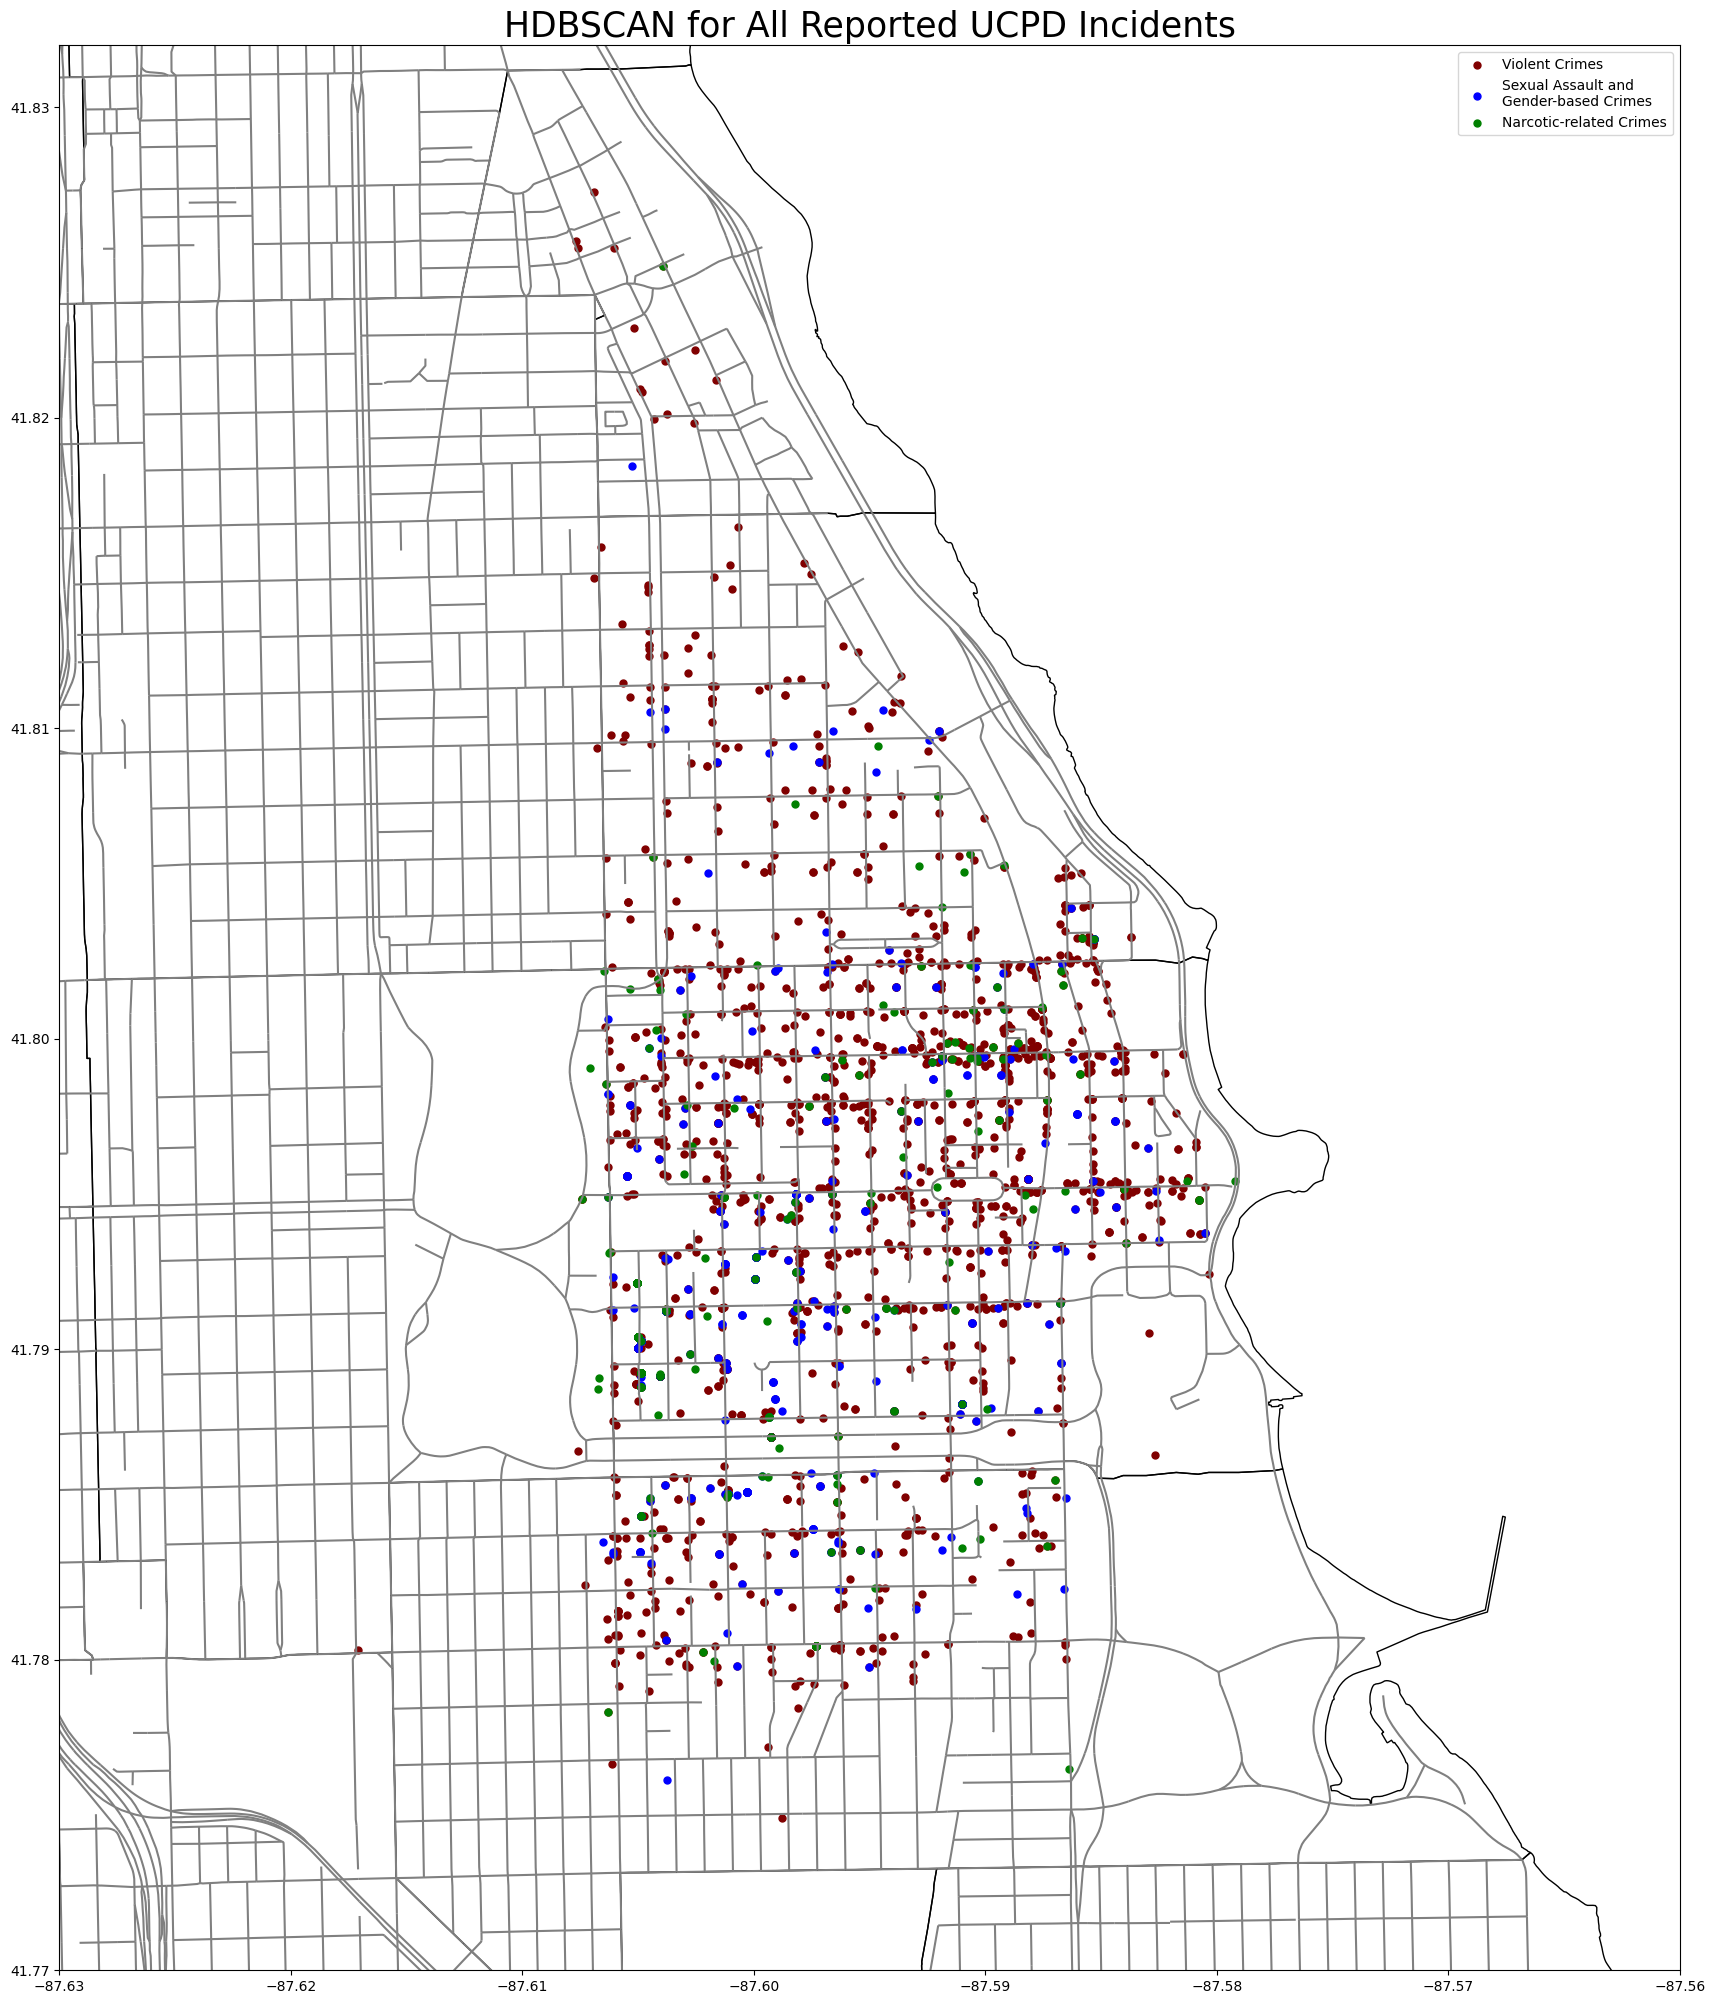

In [36]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)
chi_communities.to_crs(epsg=ESPG_NUM).plot(ax=ax, color="none", edgecolor="black")
chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=ax, color="grey")
ax.set_xlim(*VIEWPORT_X)
ax.set_ylim(*VIEWPORT_Y)
violence["All"].plot(
    ax=ax, markersize=MARKER_SIZE_CLUSTER, color="maroon", label="Violent Crimes"
)
sa_gb["All"].plot(
    ax=ax,
    markersize=MARKER_SIZE_CLUSTER,
    color="blue",
    label="Sexual Assault and\nGender-based Crimes",
)
narcotics["All"].plot(
    ax=ax,
    markersize=MARKER_SIZE_CLUSTER,
    color="green",
    label="Narcotic-related Crimes",
)
plt.legend()
plt.title("HDBSCAN for All Reported UCPD Incidents", fontsize=25)
plt.savefig("all-crimes-overlap.png")

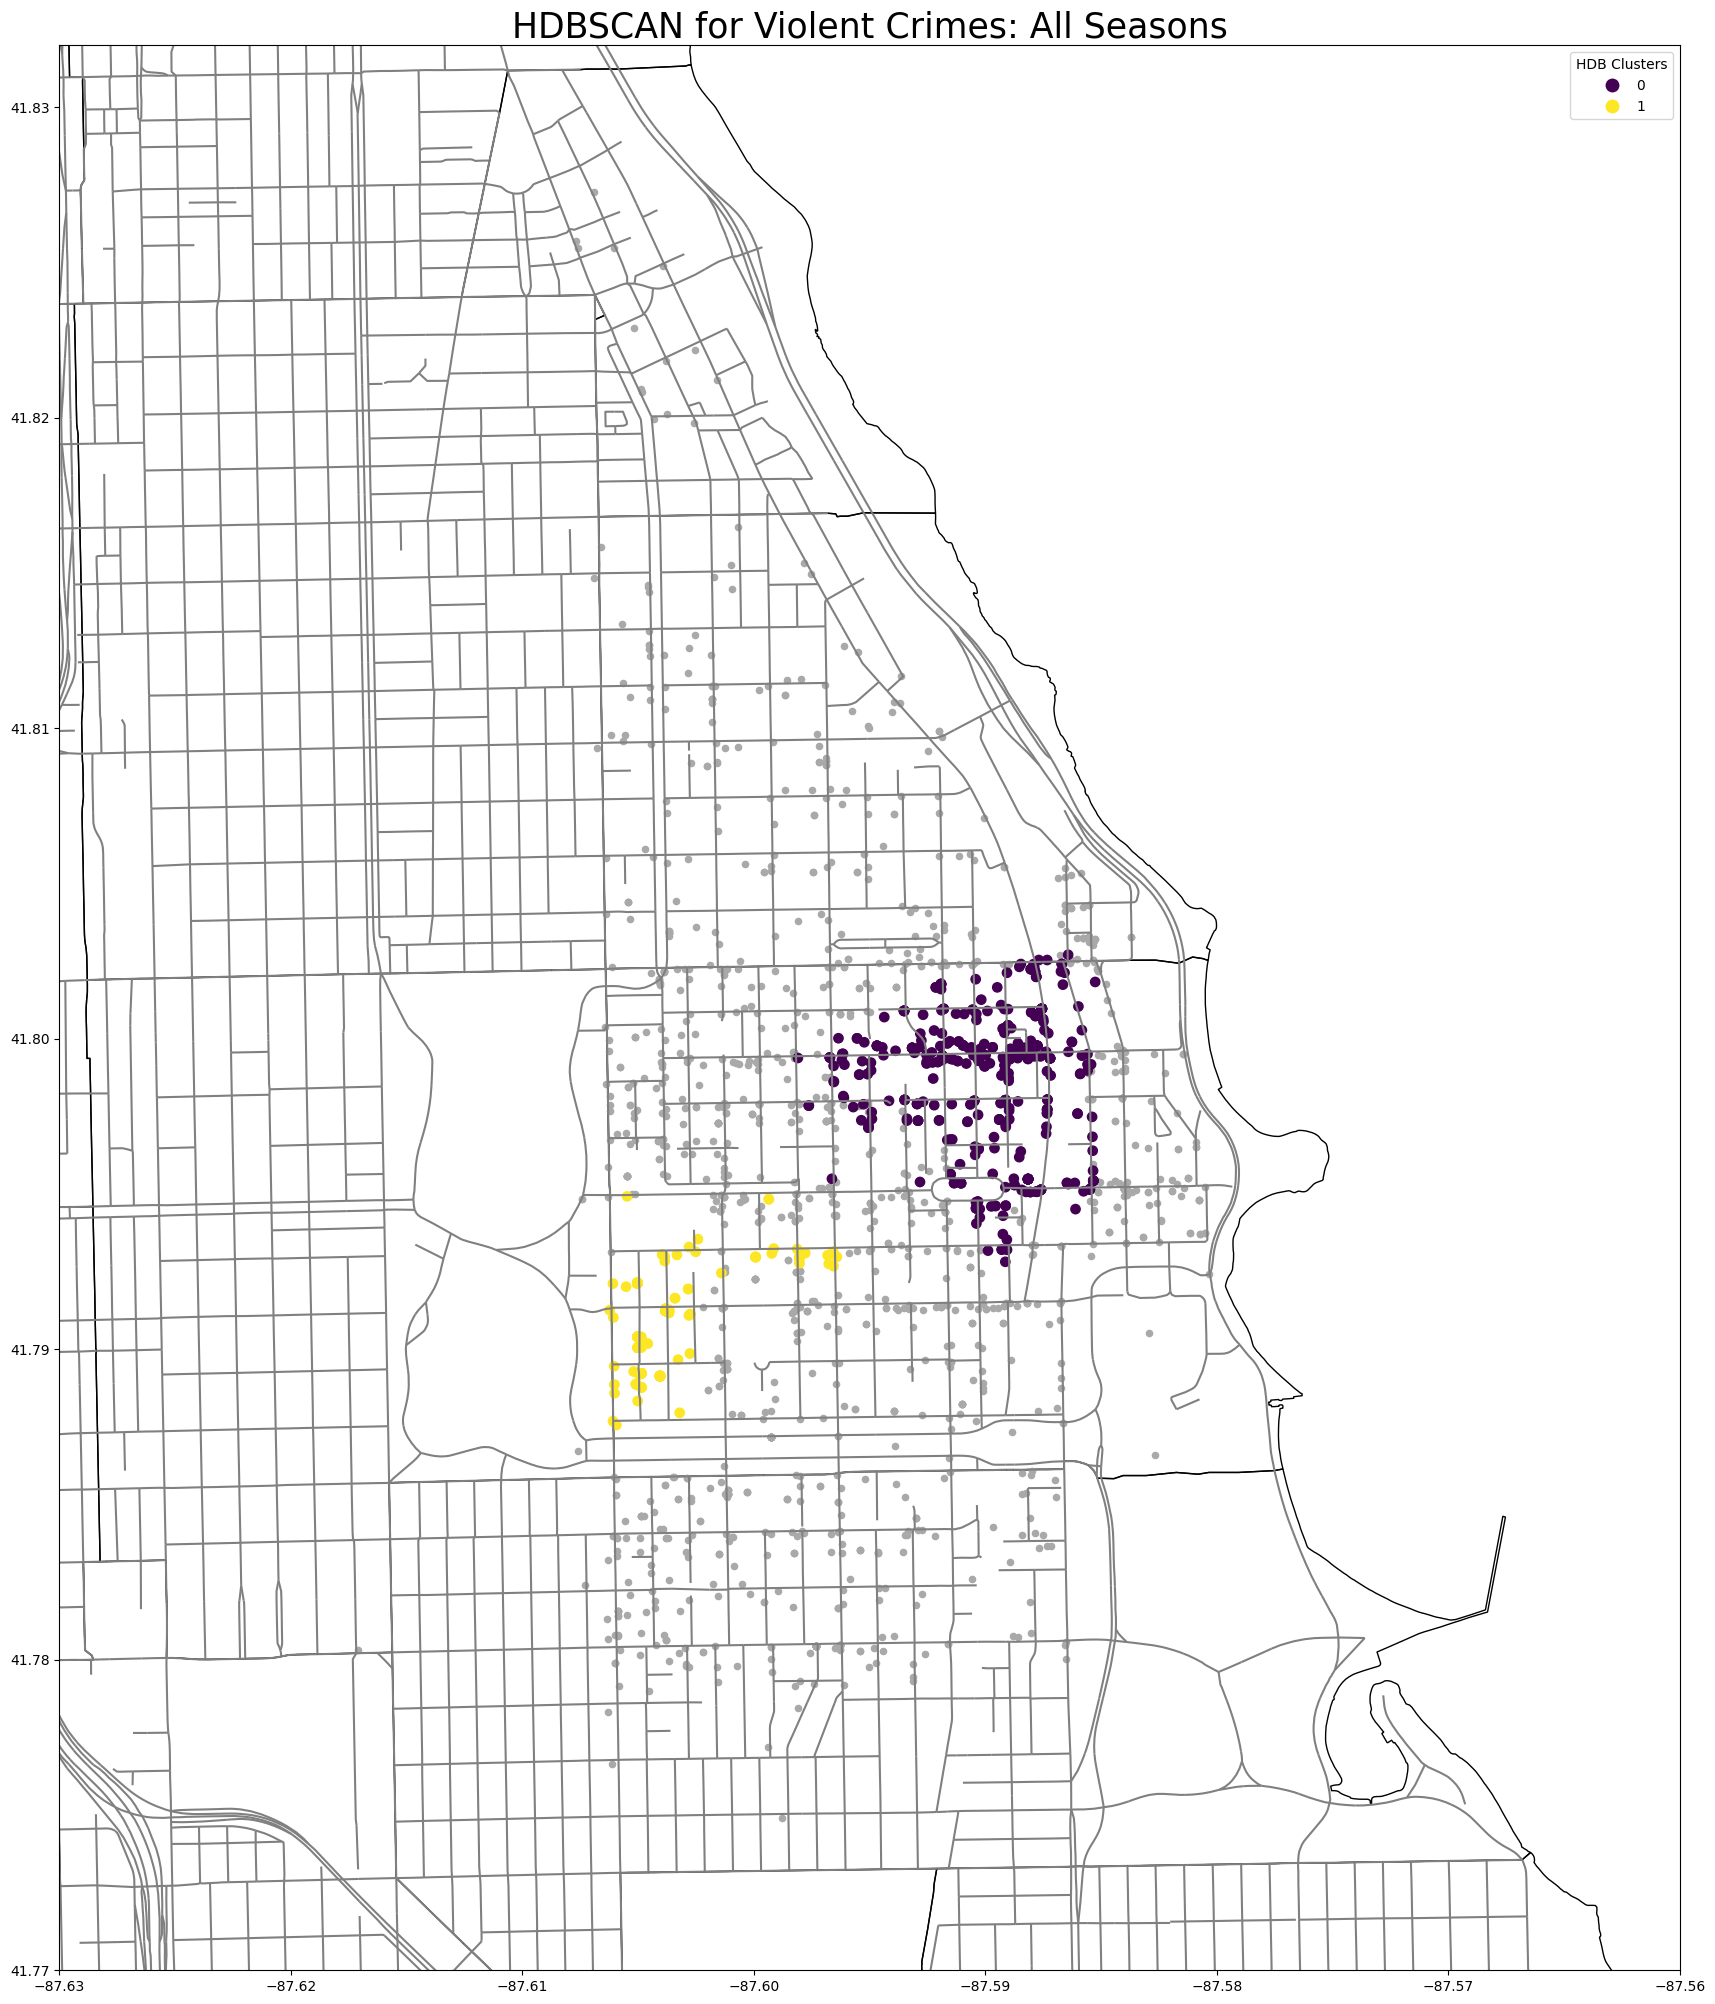

In [37]:
hdbscan_plotting(violence["All"], "violent crimes: all seasons")

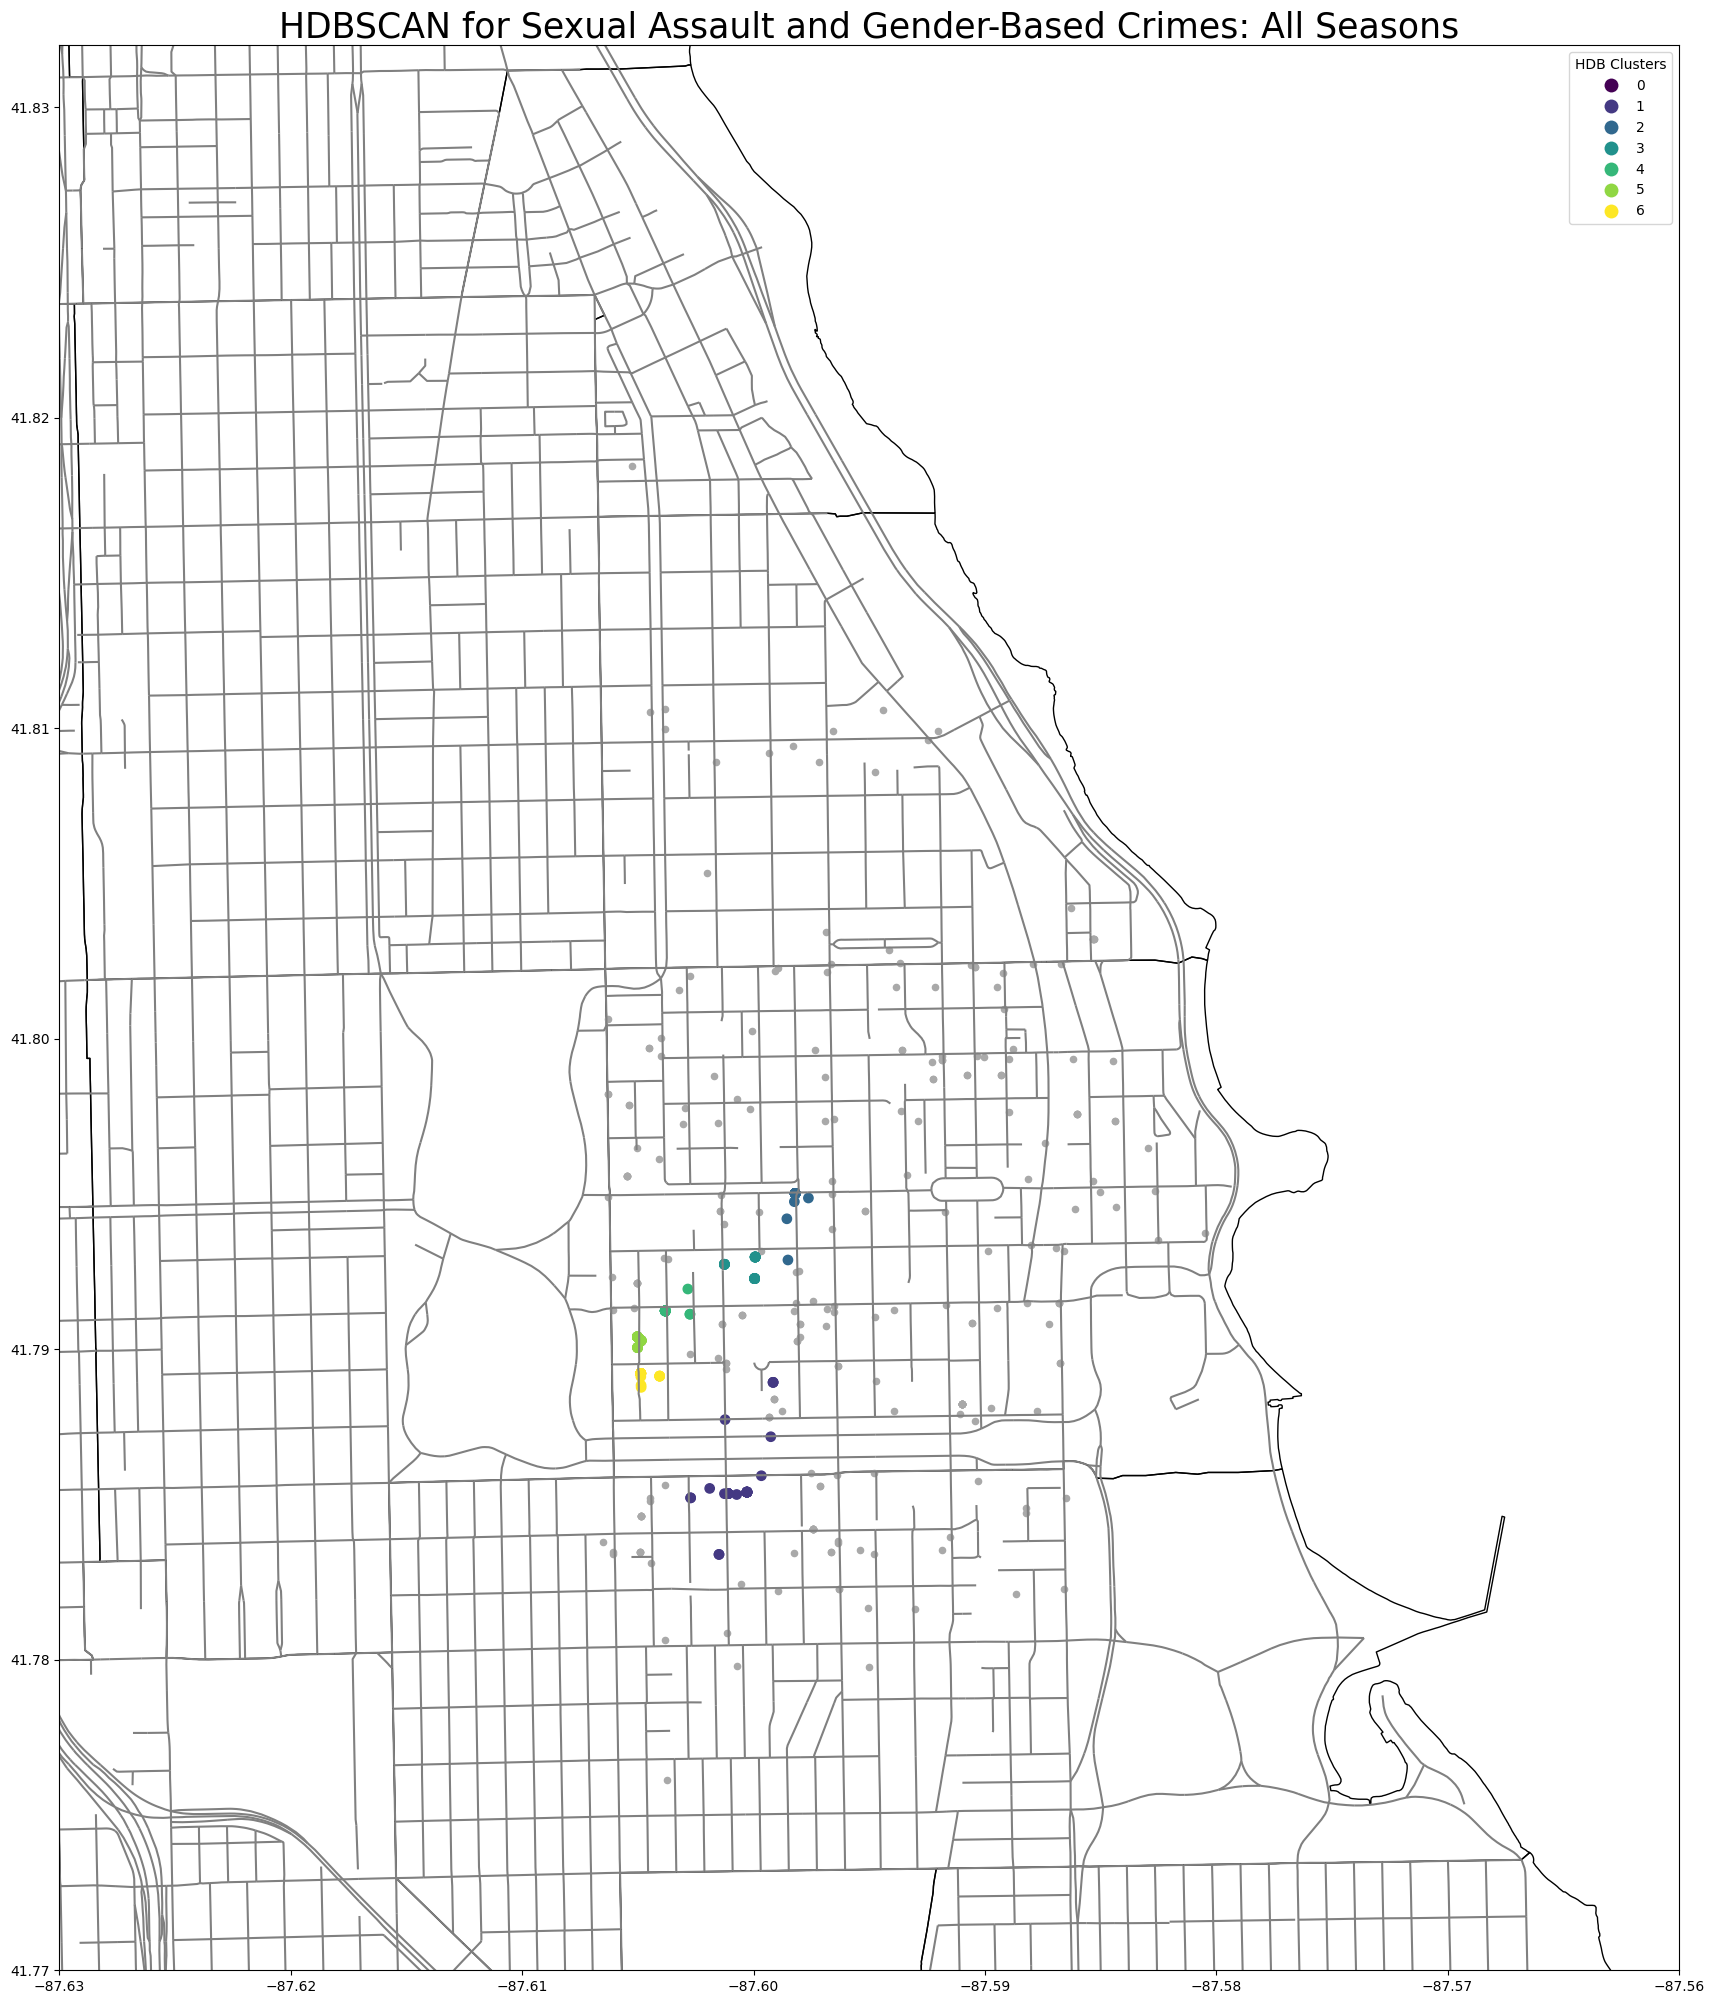

In [38]:
hdbscan_plotting(sa_gb["All"], "sexual assault and gender-based crimes: all seasons")

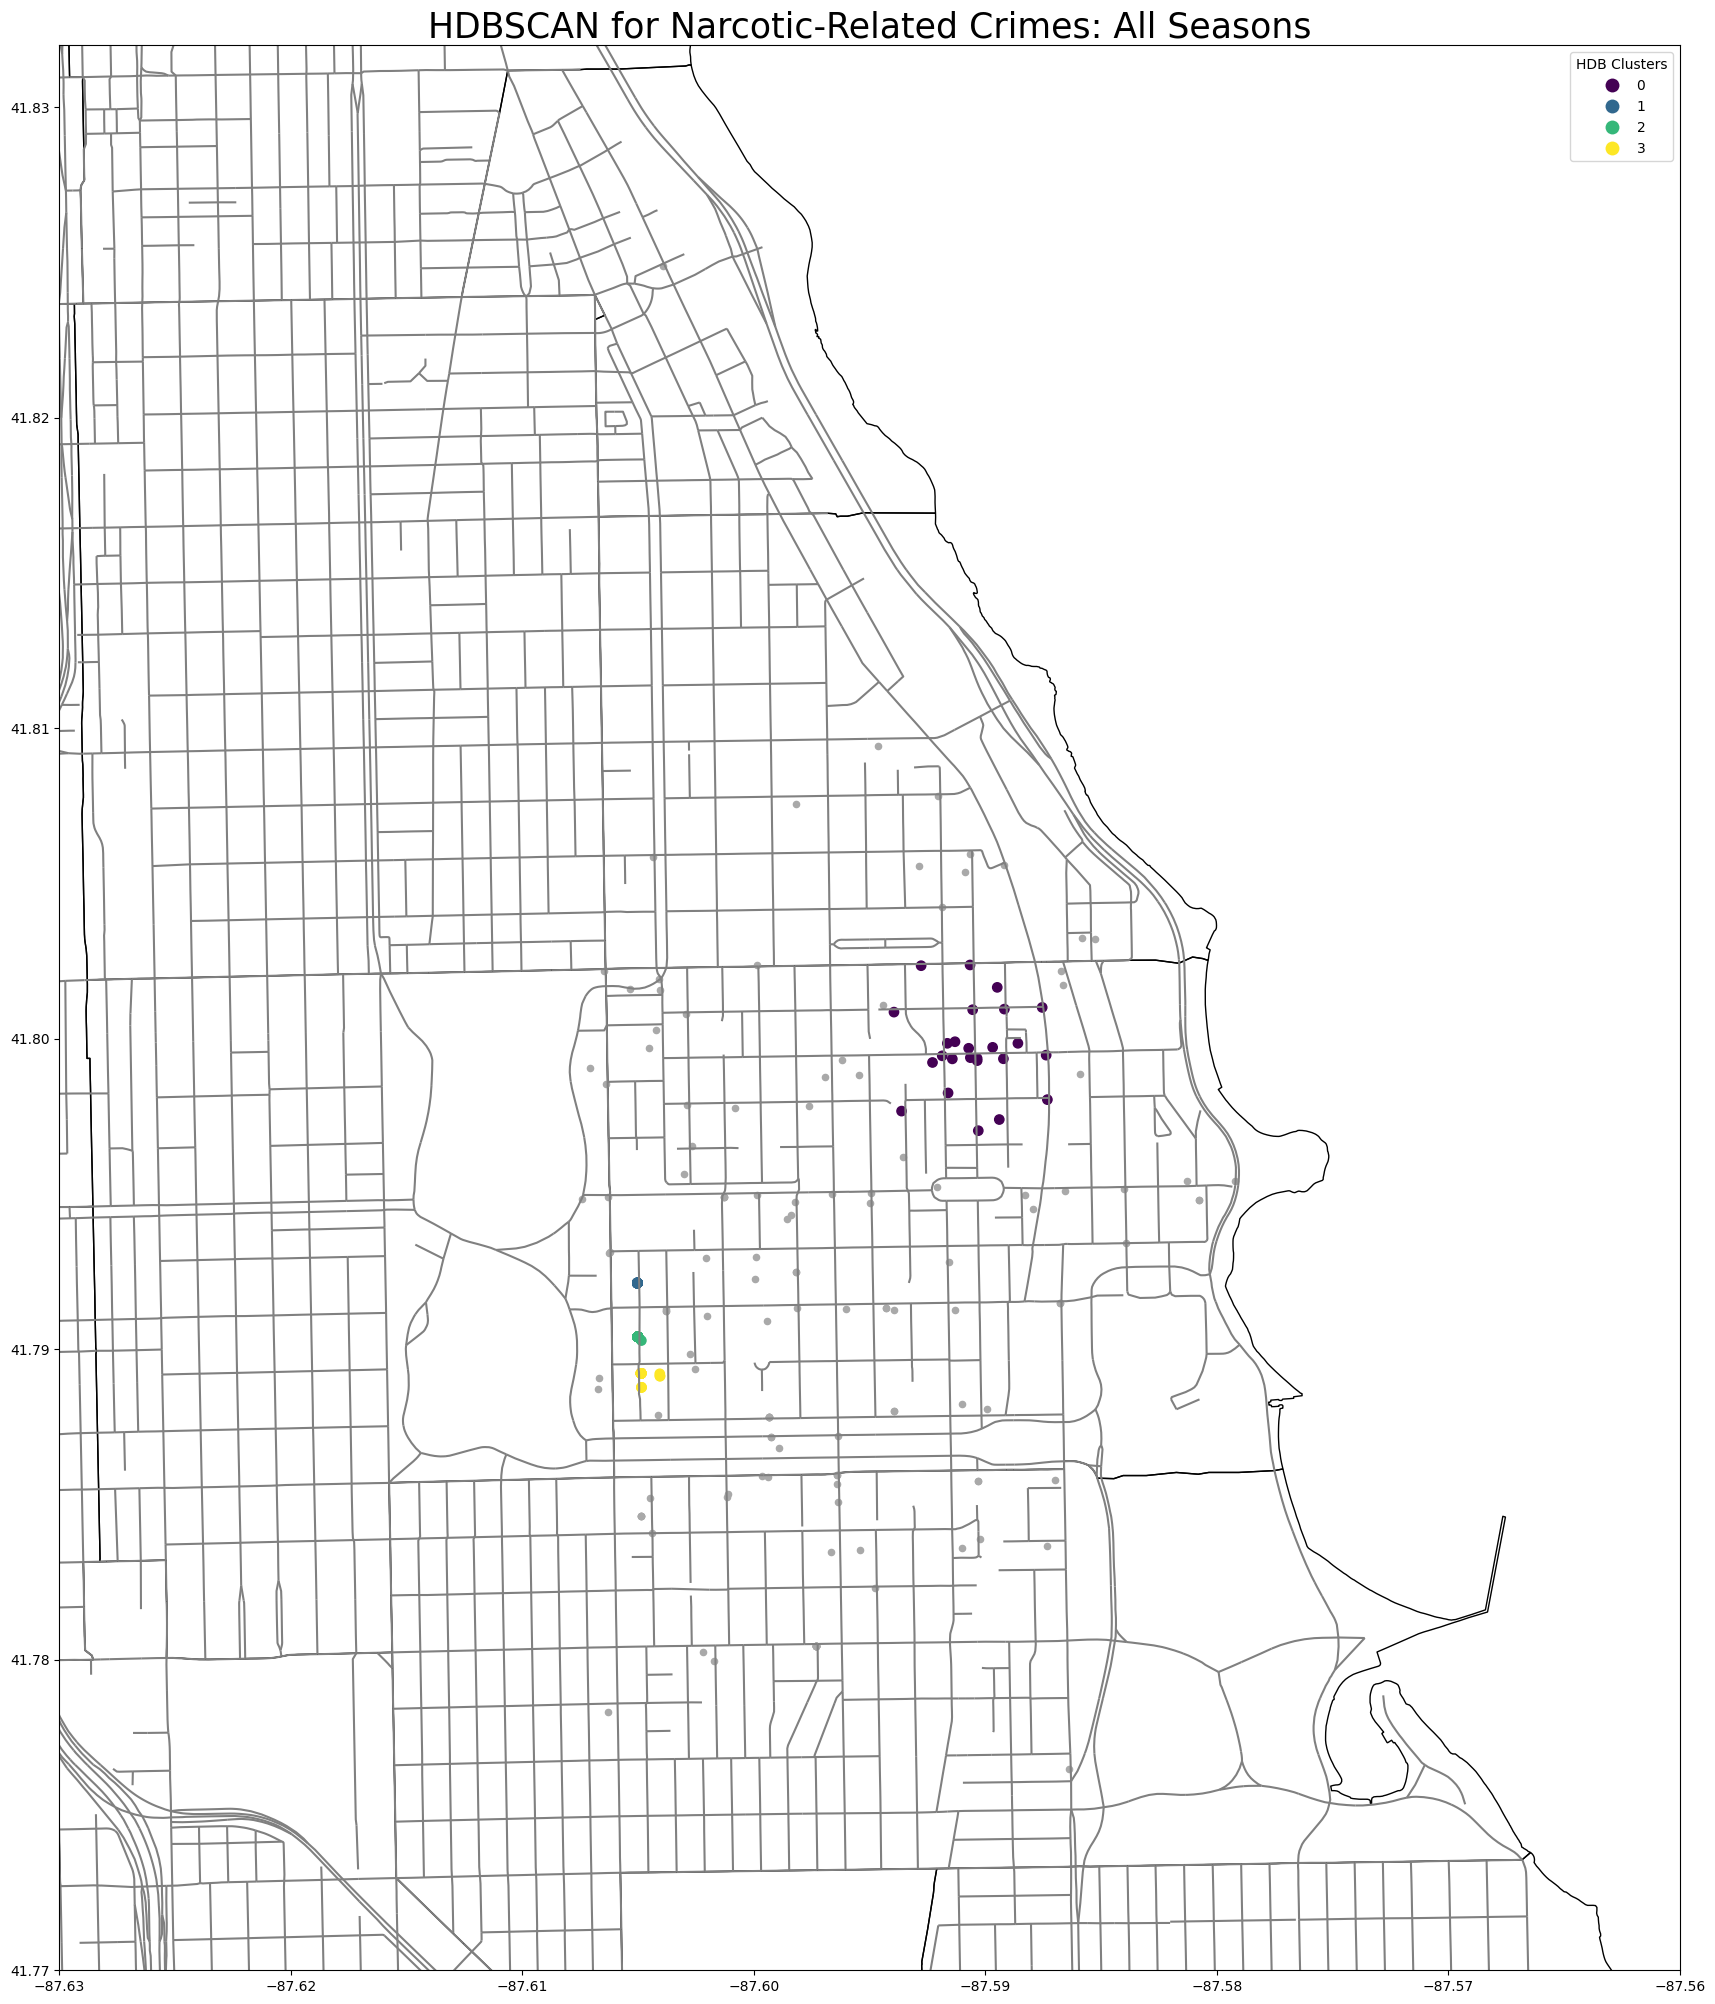

In [39]:
hdbscan_plotting(narcotics["All"], "narcotic-related crimes: all seasons")

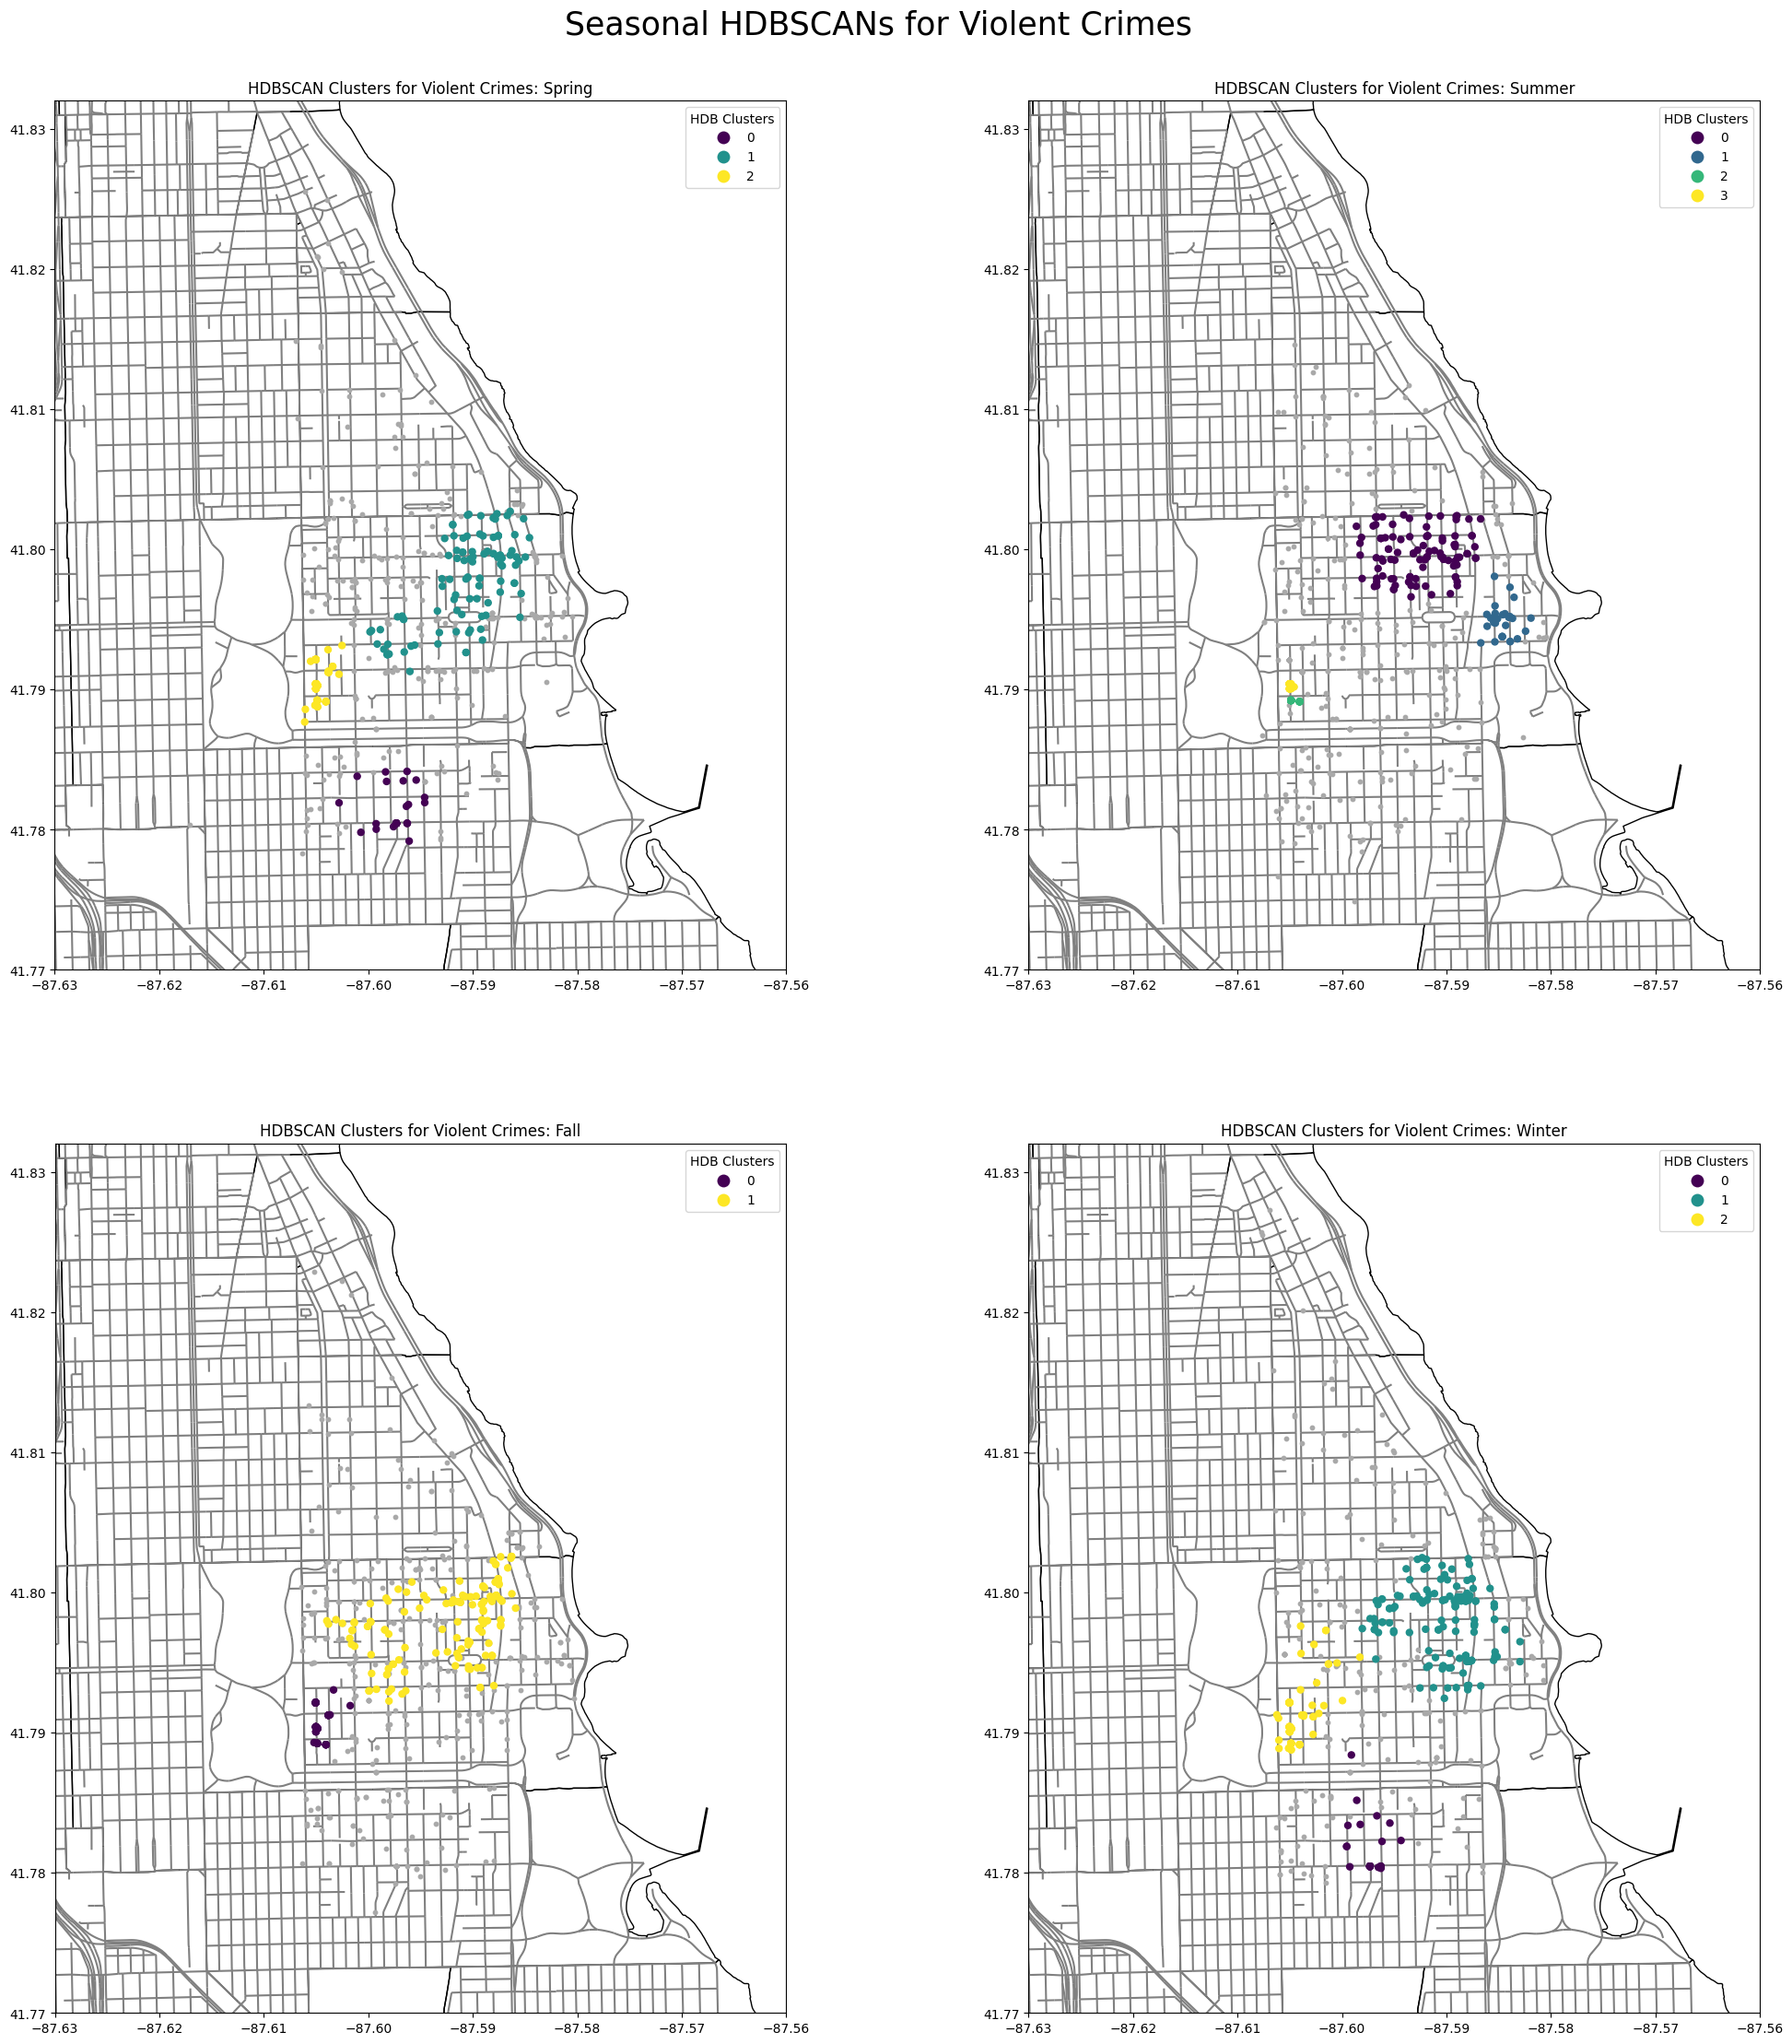

In [40]:
create_four_seasons_png(violence, "Violent")

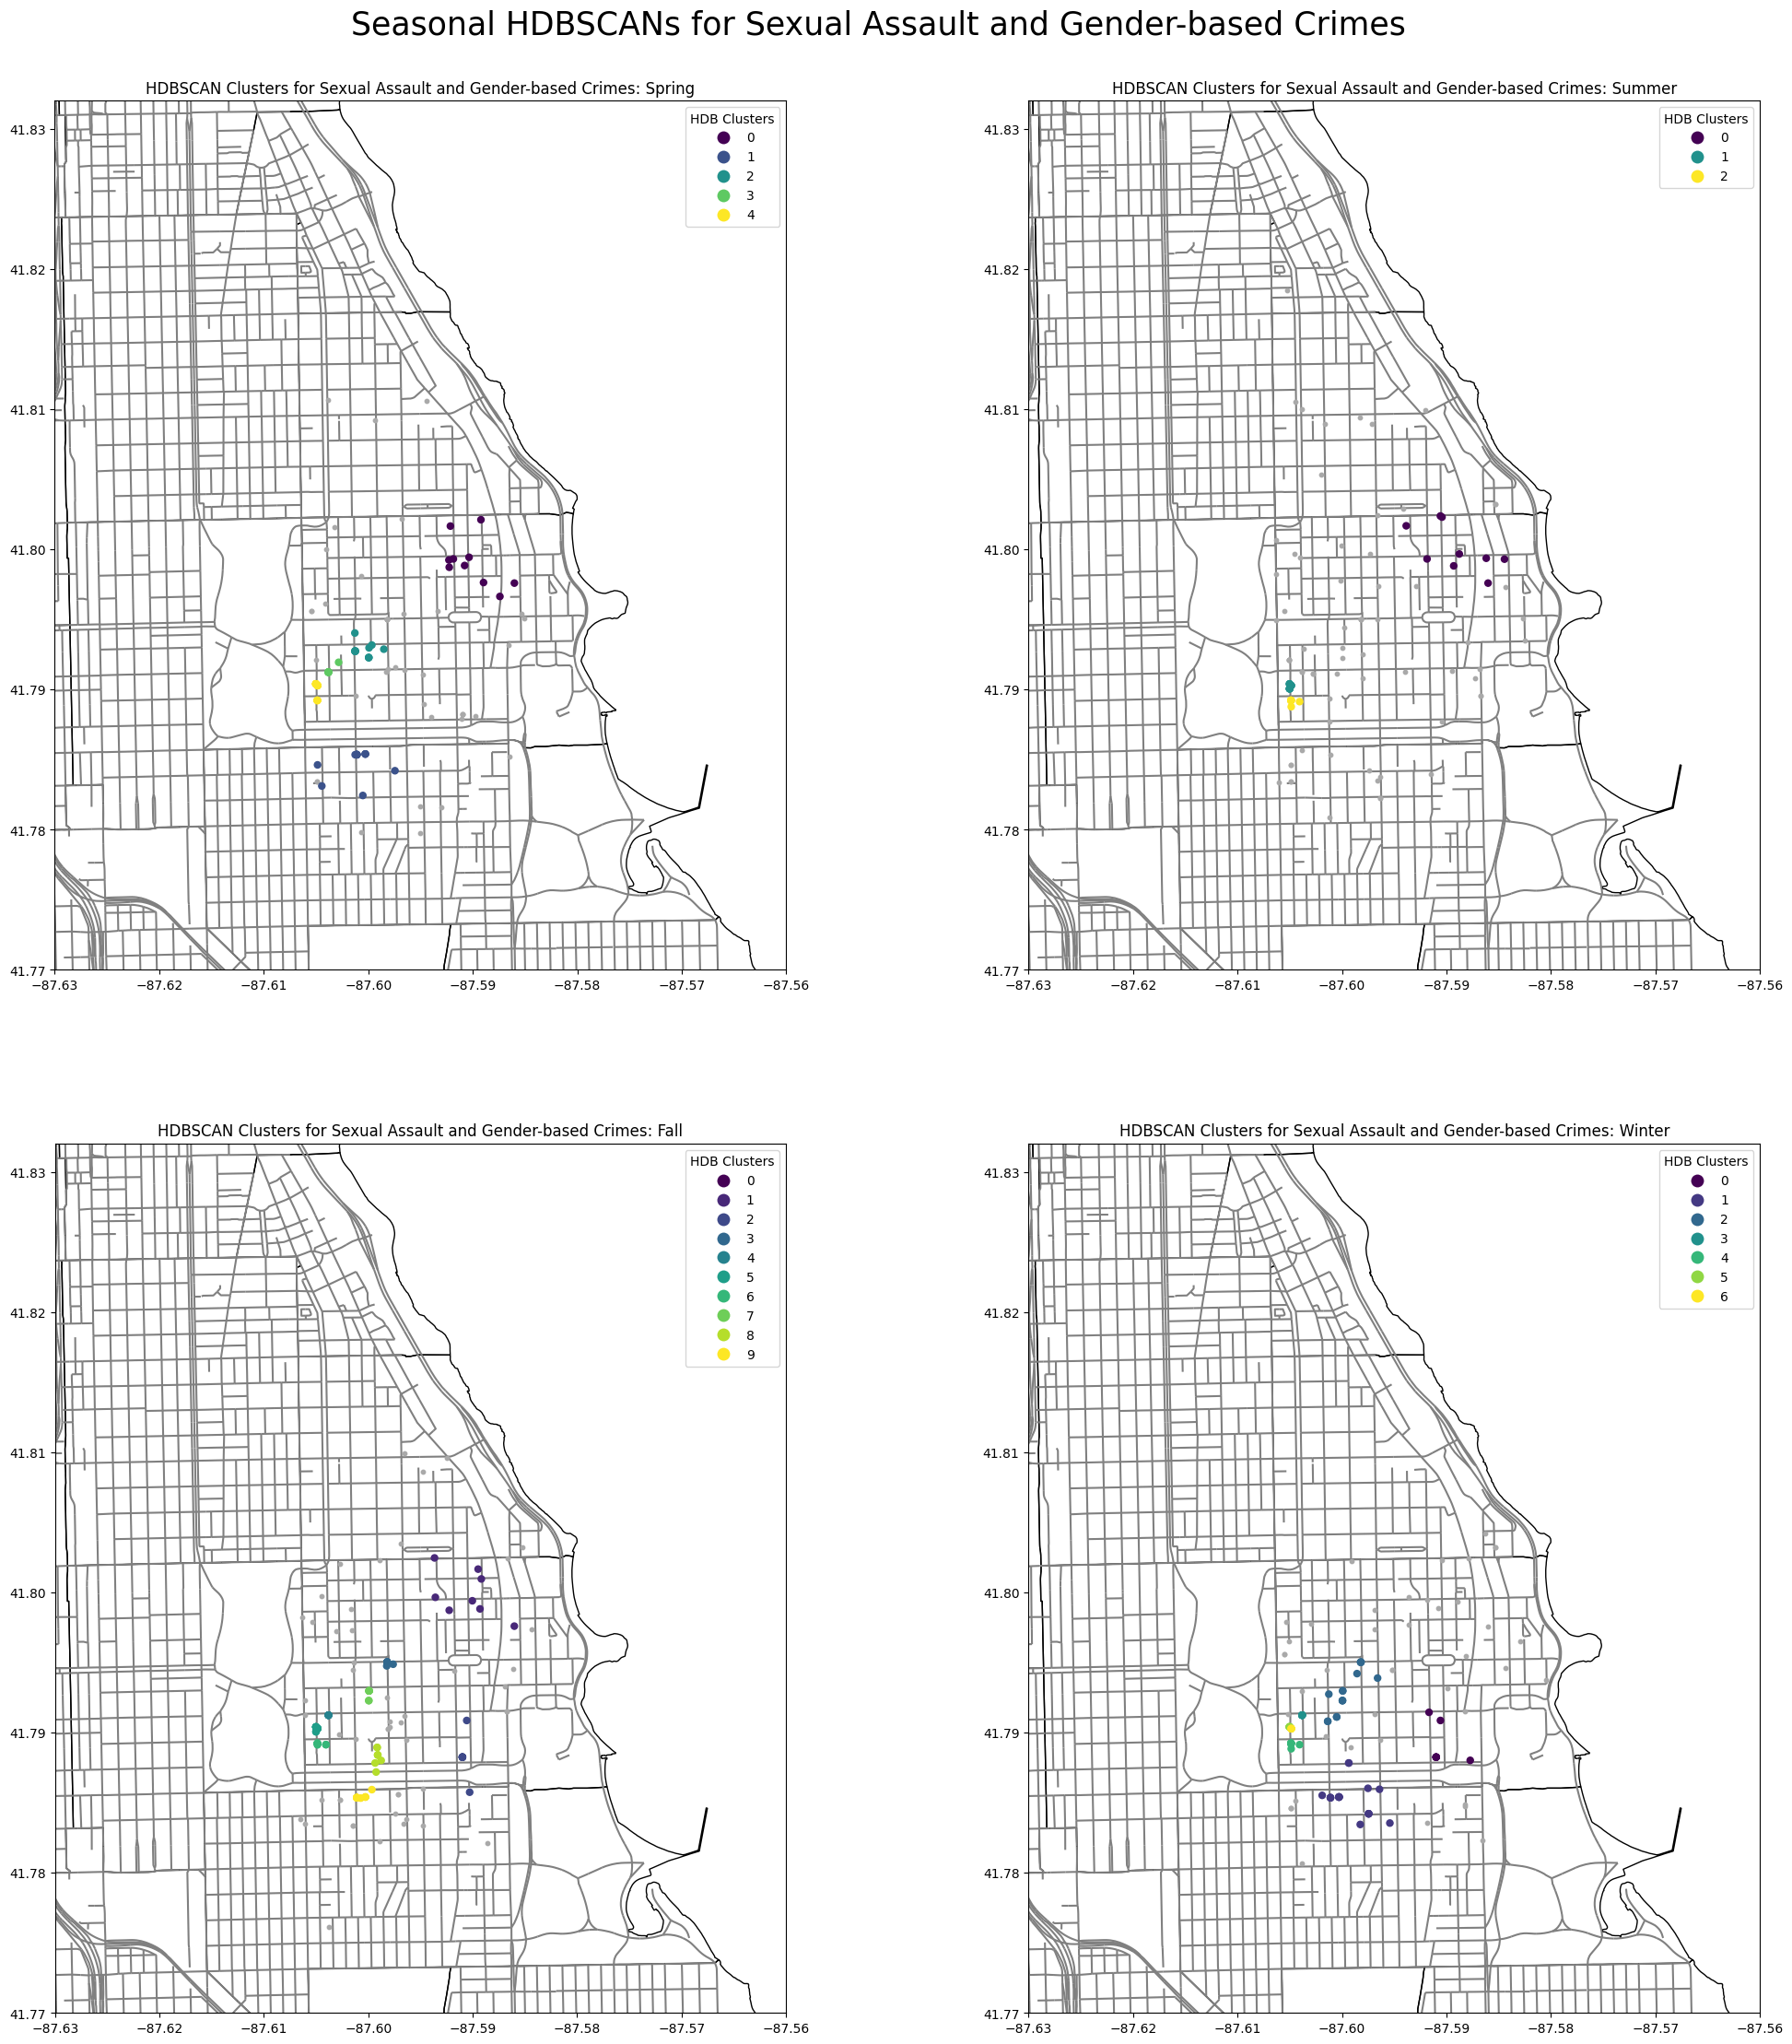

In [41]:
create_four_seasons_png(sa_gb, "Sexual Assault and Gender-based")

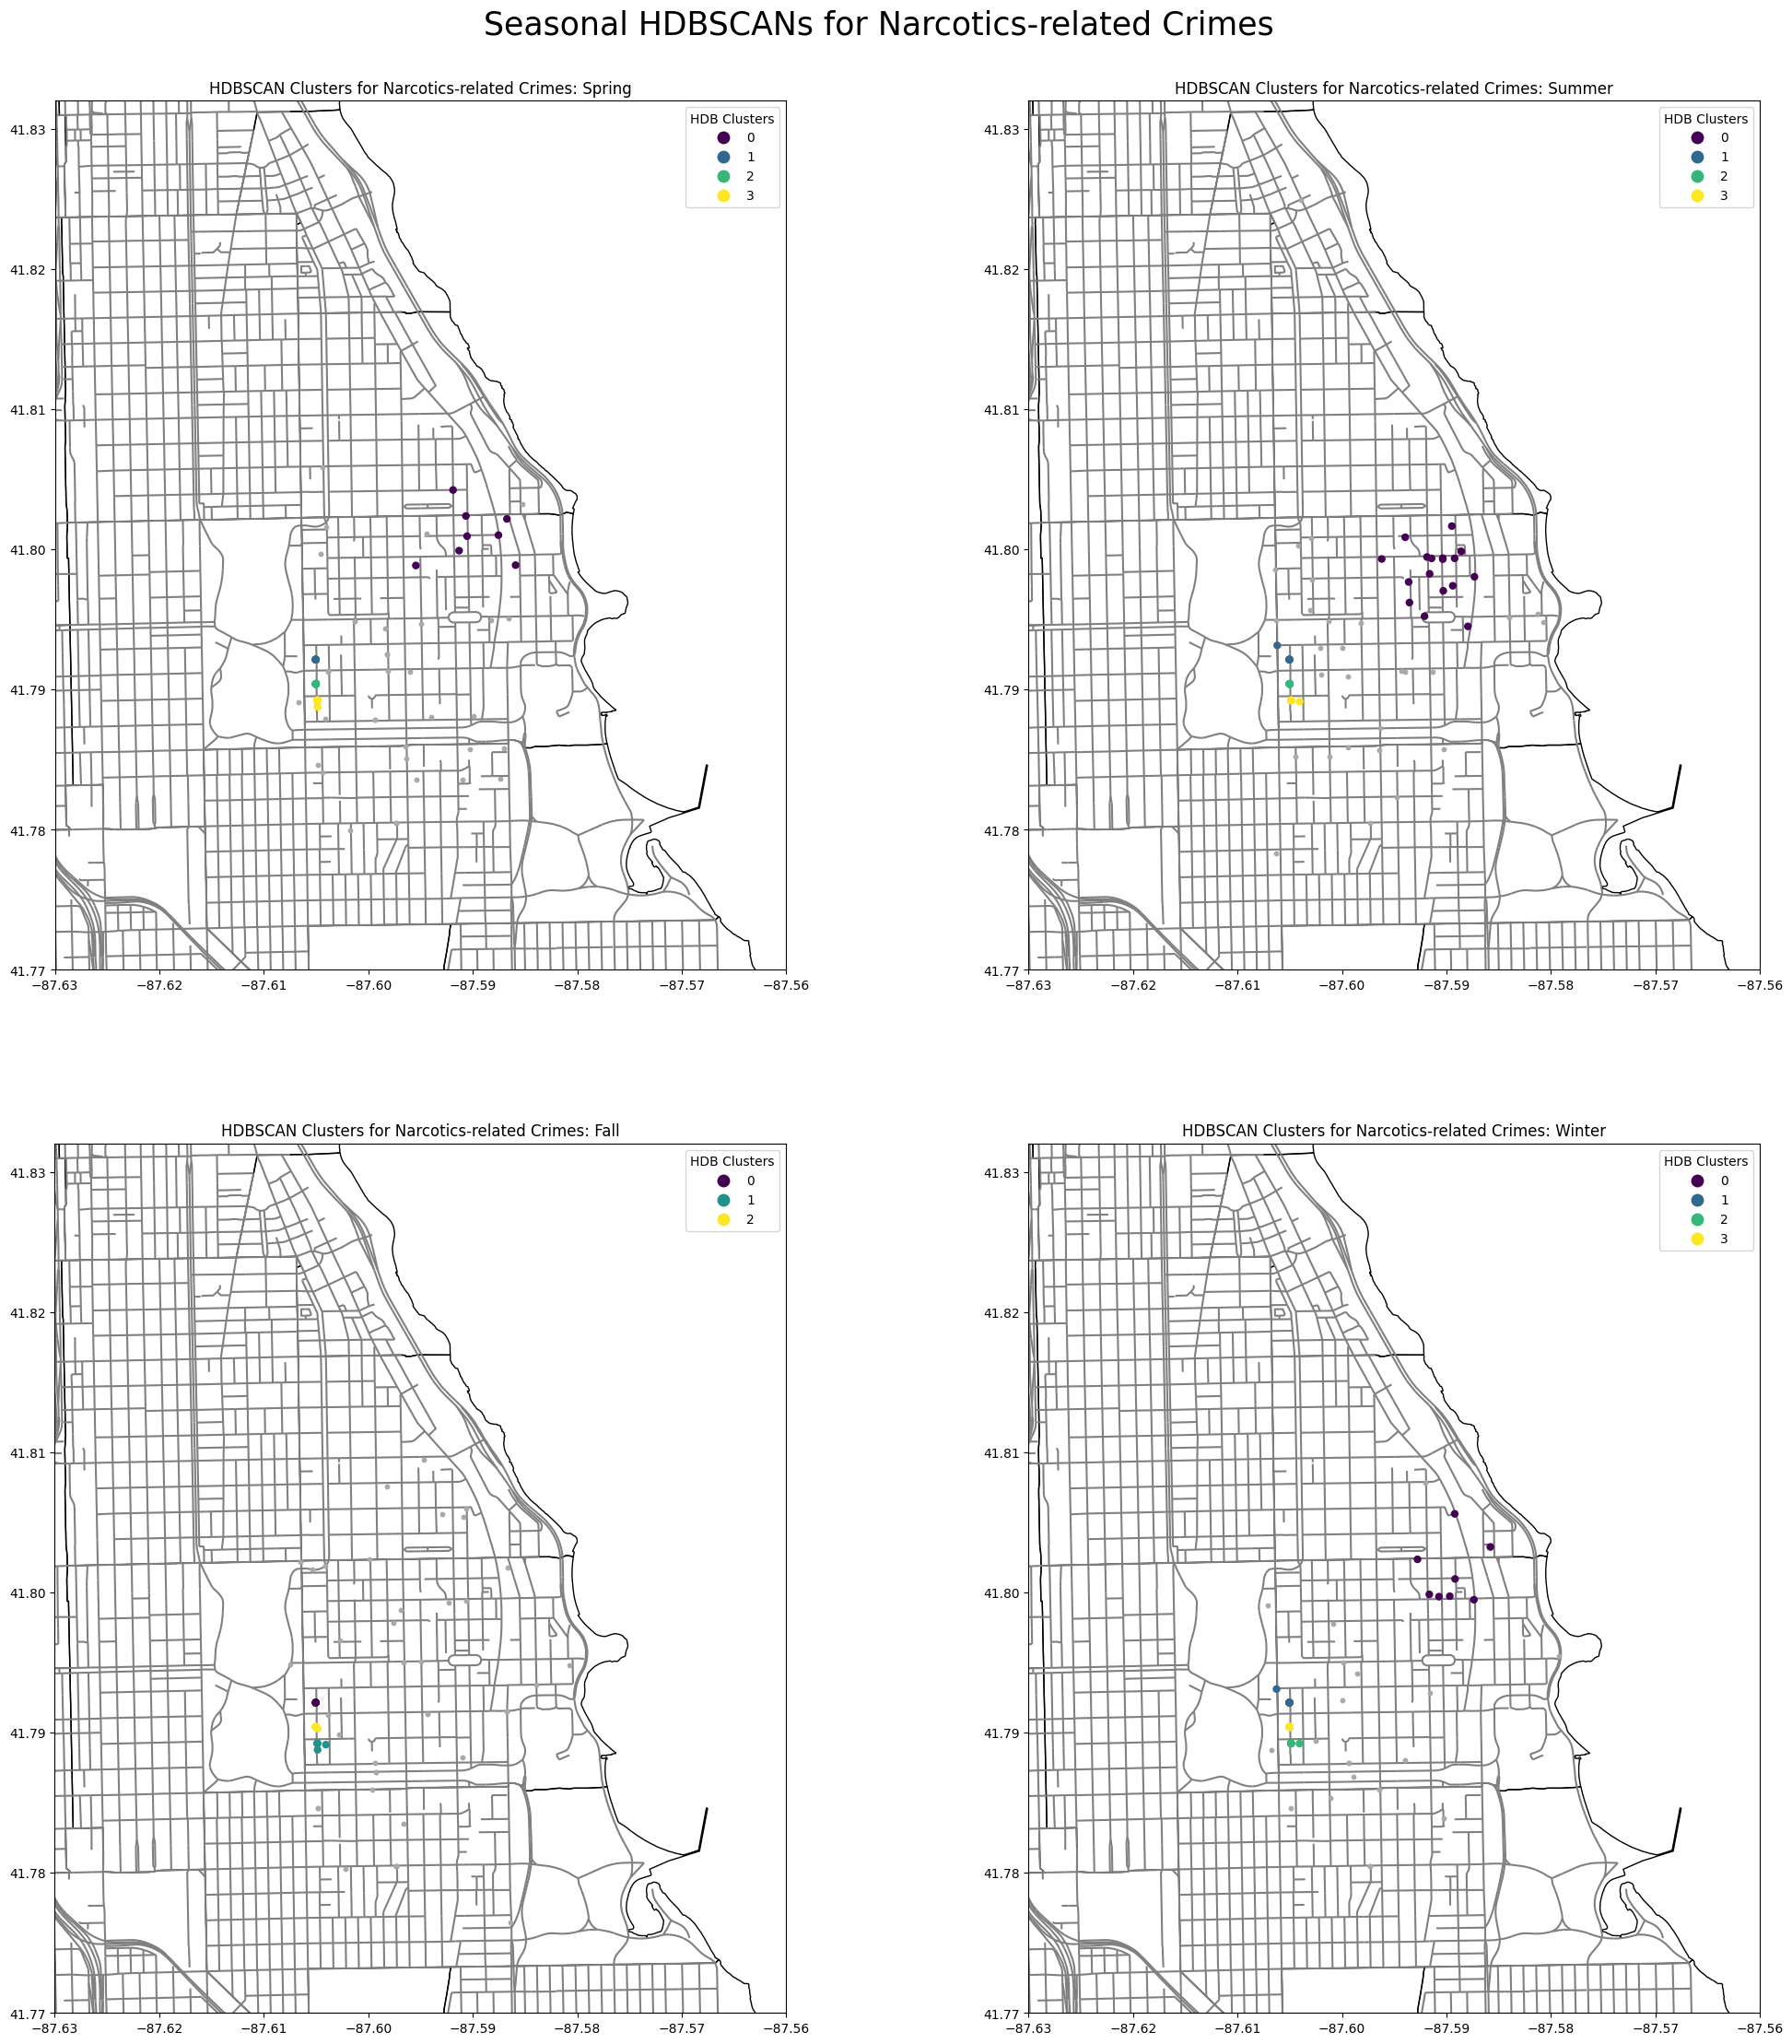

In [42]:
create_four_seasons_png(narcotics, "Narcotics-related")